In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, TensorBoard
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error 
from tensorflow.keras.backend import clear_session
import gc

In [2]:
data = pd.read_csv('all_data_results_cleaned.csv')

In [3]:
to_drop=["pipe_dn","pipe_schedule","flange_class",
        "hot_spot_stress", "max_deformation", "support_right", "support_left", "ratio"]
to_keep=["outside_diameter", "wall_thickness", "raised_face_depth",
        "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius",
        "length1", "length2", "lumped_mass", "frequency", "x_deformation_position",
        "y_deformation_position", "z_deformation_position", "support", "allowable_deformation"]

data.drop(columns=to_drop,inplace=True)

In [4]:
numeric_features = ["outside_diameter", "wall_thickness", "raised_face_depth" ,'length1', 'length2', 'lumped_mass',
                    "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius"]
categorical_features = ['support']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop=None), categorical_features)
    ])

In [5]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [6]:
output_columns = ['allowable_deformation', 'frequency', 'x_deformation_position', 'y_deformation_position', 'z_deformation_position']
x = data.drop(output_columns, axis=1)
y = pd.DataFrame(data[output_columns])

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [8]:
x_train_transformed = pipeline.fit_transform(x_train)
x_test_transformed = pipeline.transform(x_test)

In [9]:
scaler_y_frequency = StandardScaler()
scaler_y_allowable_deformation = StandardScaler()

#y_train_transformed_frequency = scaler_y_frequency.fit_transform(pd.DataFrame(y_train["frequency"]))
#y_test_transformed_frequency = scaler_y_frequency.transform(pd.DataFrame(y_test["frequency"]))

y_train_transformed_allowable_deformation = scaler_y_allowable_deformation.fit_transform(pd.DataFrame(y_train["allowable_deformation"]))
y_test_transformed_allowable_deformation = scaler_y_allowable_deformation.transform(pd.DataFrame(y_test["allowable_deformation"]))
"""
y_train_transformed_x_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["x_deformation_position"]))
y_test_transformed_x_displacement = scaler_y.transform(pd.DataFrame(y_test["x_deformation_position"]))

y_train_transformed_y_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["y_deformation_position"]))
y_test_transformed_y_displacement = scaler_y.transform(pd.DataFrame(y_test["y_deformation_position"]))

y_train_transformed_z_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["z_deformation_position"]))
y_test_transformed_z_displacement = scaler_y.transform(pd.DataFrame(y_test["z_deformation_position"]))
"""

'\ny_train_transformed_x_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["x_deformation_position"]))\ny_test_transformed_x_displacement = scaler_y.transform(pd.DataFrame(y_test["x_deformation_position"]))\n\ny_train_transformed_y_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["y_deformation_position"]))\ny_test_transformed_y_displacement = scaler_y.transform(pd.DataFrame(y_test["y_deformation_position"]))\n\ny_train_transformed_z_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["z_deformation_position"]))\ny_test_transformed_z_displacement = scaler_y.transform(pd.DataFrame(y_test["z_deformation_position"]))\n'

In [10]:
logdir = "logs/Deformation/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [11]:
input_layer = Input(shape=(x_train_transformed.shape[1],))
hidden1 = Dense(512, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
hidden2 = Dense(128, activation='relu')(dropout1)


# Separate output for each target variable
output_layer = Dense(1)(hidden2)
#, name='allowable_deformation'


In [12]:
model = Model(inputs=input_layer, outputs=output_layer)

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,473 (287.00 KB)

 Trainable params: 73,473 (287.00 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='mse',
              metrics=["R2Score"])

In [15]:
history = model.fit(
    x_train_transformed, 
    y_train_transformed_allowable_deformation,  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - R2Score: 0.4916 - loss: 0.5790 - val_R2Score: 0.8900 - val_loss: 0.1016
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - R2Score: 0.8998 - loss: 0.0994 - val_R2Score: 0.9232 - val_loss: 0.0709
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - R2Score: 0.9253 - loss: 0.0753 - val_R2Score: 0.9359 - val_loss: 0.0593
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - R2Score: 0.9321 - loss: 0.0668 - val_R2Score: 0.9281 - val_loss: 0.0664
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - R2Score: 0.9439 - loss: 0.0577 - val_R2Score: 0.9436 - val_loss: 0.0522
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - R2Score: 0.9475 - loss: 0.0500 - val_R2Score: 0.9384 - val_loss: 0.0569
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - R2Score: 0.9481 - loss: 0.0507 - val_R2Score: 0.9378 - val_loss: 0.0574
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - R2Score: 0.9527 - loss: 0.0505 - val_R2Score: 0.9561 - v

In [16]:
test_loss, test_mse = model.evaluate(x_test_transformed, y_test_transformed_allowable_deformation)
print('Test accuracy:', test_mse)

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - R2Score: 0.9774 - loss: 0.0257
Test accuracy: 0.9776824116706848


In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,421 (861.02 KB)

 Trainable params: 73,473 (287.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 146,948 (574.02 KB)

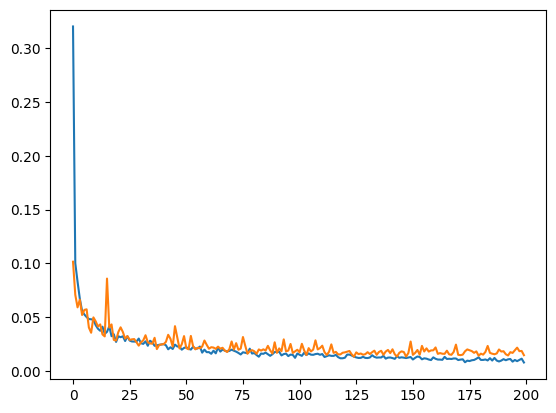

In [18]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")

In [19]:
predictions_scaled = model.predict(x_test_transformed)
predictions = scaler_y_allowable_deformation.inverse_transform((predictions_scaled))

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [20]:
predictions_df = pd.DataFrame(predictions)
print("\nSample Predictions:")
print(predictions_df)


Sample Predictions:
              0
0     12.175782
1     11.205060
2      5.593694
3     14.460074
4     14.812934
...         ...
2452   3.158526
2453   6.288835
2454   3.131510
2455   1.935225
2456  11.853642

[2457 rows x 1 columns]


In [21]:
y_test["allowable_deformation"]

524      13.586
10325    11.513
11646     5.124
10238    13.693
10214    15.469
          ...  
11507     3.243
2709      3.497
12218     2.108
2858      1.647
9935     10.959
Name: allowable_deformation, Length: 2457, dtype: float64

In [22]:
true= y_test["allowable_deformation"].tolist()
pred= predictions_df[0].tolist()
mean_squared_error(true,pred)

142.69662430290052

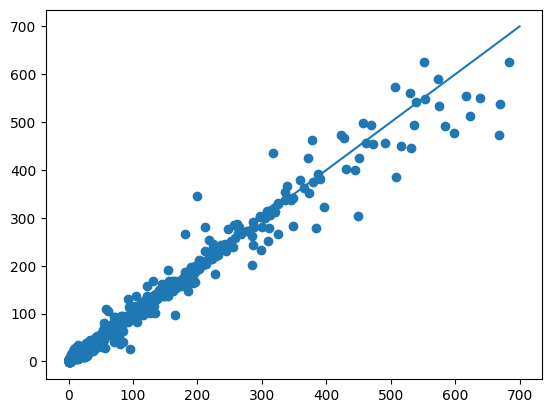

In [26]:
pred=predictions_df
ansys=y_test["allowable_deformation"]
plt.scatter(ansys,pred)
#plt.loglog()
plt.plot([0, 700],[0, 700])
plt.show()

In [25]:
clear_session()
del model
gc.collect()

0